In [84]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
import scipy
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from math import pi

In [85]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']

In [319]:
#Good events for run_0102 are: 689 (fair ~37), 765 (good), 896 (good), 305 (perfect), 504 (not good ~65)
#575, 456, 299, 399, 156, 231, 7832, 1568, 789, 485
full = h5py.File('/home/chen/Real Data/clean_run_0102.h5', 'r')
evt_ID = 485
dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]

xyzs = np.array(xyzs_h5)

#delete the points which are farther away from the center of the spiral
del_list = []
print(max(xyzs[:, 6]))
for i in range(len(xyzs)):
    if (xyzs[i,6]) > 150.0:
        del_list.append(i)
cut_xyzs = np.delete(xyzs,del_list,axis=0)
print(max(cut_xyzs[:, 6]))
print(del_list)

1511.8938480739068
140.67038182369026
[48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 84]


In [320]:
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)

cut_xy = cut_xyzs[:, 0:2]
cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

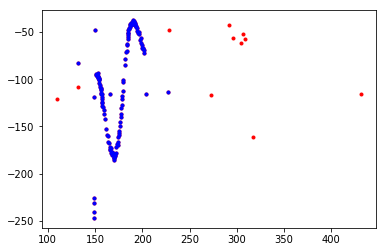

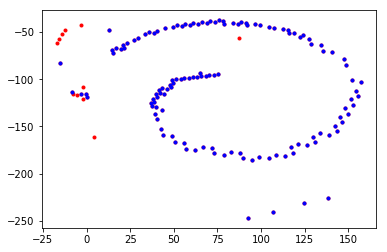

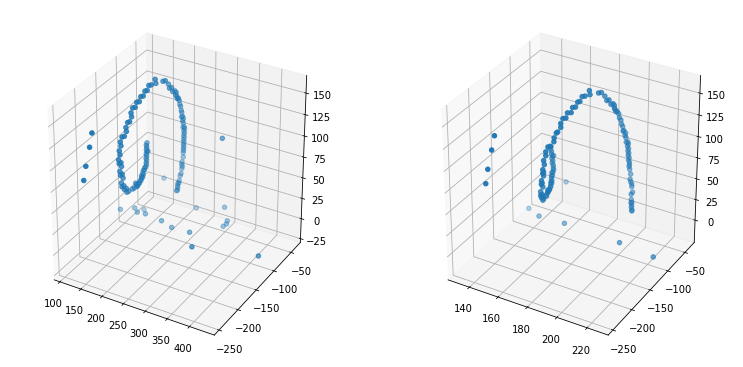

In [321]:
%matplotlib inline
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 2], cut_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 0], cut_xyzs[:, 1], 'b.')
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(xyzs[:,2],xyzs[:,1],xyzs[:,0])
ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(cut_xyzs[:,2],cut_xyzs[:,1],cut_xyzs[:,0])

<IPython.core.display.Javascript object>


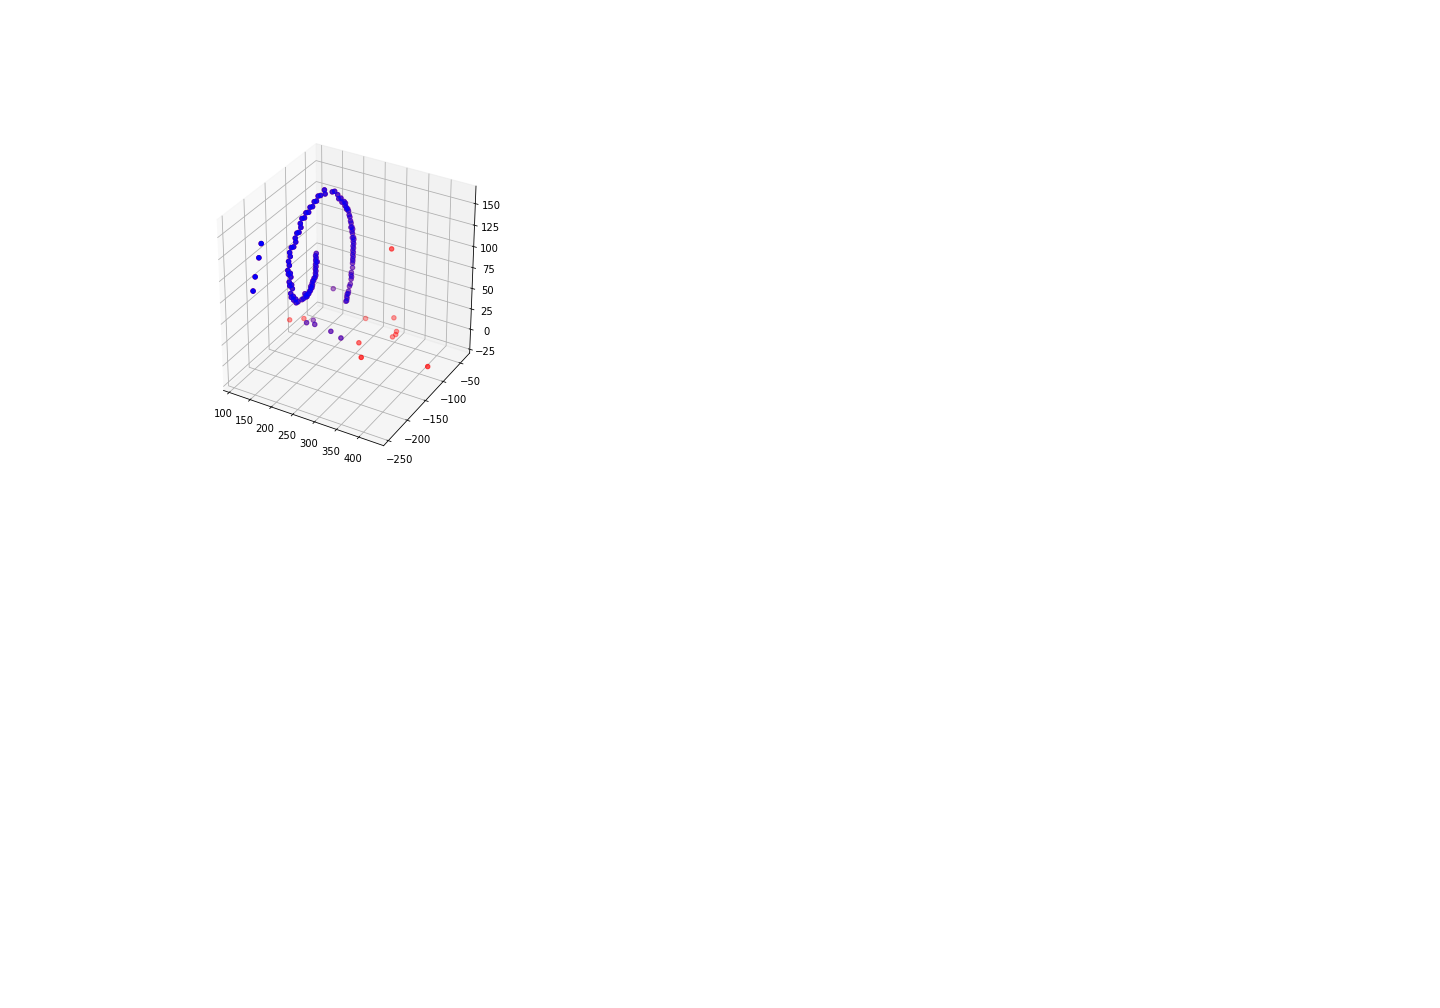

In [322]:
%matplotlib notebook

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(xyzs[:,2],xyzs[:,1],xyzs[:,0], c='r', label='original data')
ax.scatter(cut_xyzs[:,2],cut_xyzs[:,1],cut_xyzs[:,0], c='b', label='after cut')


In [325]:
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
uvw_values = uvw.values

cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
cut_uvw_values = cut_uvw.values

In [326]:
uvw_sorted = uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
ctr0 = mcfitter.guess_parameters(prefit_res)
exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000

cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000

In [327]:
exp_hits = np.zeros(10240)
for a, p in uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
cut_exp_hits = np.zeros(10240)
for a, p in cut_uvw[['a', 'pad']].values:
    cut_exp_hits[int(p)] = a

In [328]:
minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)

Conjugate Gradient

In [329]:
def f(y):
    ctr = np.zeros([1,6])
    ctr[0] = y
    chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
    return sum(chi_result[0])
eps = np.sqrt(np.finfo(np.float).eps)
def jacobian(x):
    return scipy.optimize.approx_fprime(x,f,1e-13)


In [330]:
def cut_f(y):
    ctr = np.zeros([1,6])
    ctr[0] = y
    chi_result = minimizer.run_tracks(ctr, cut_exp_pos, cut_exp_hits)
    return sum(chi_result[0])
eps = np.sqrt(np.finfo(np.float).eps)
def cut_jacobian(x):
    return scipy.optimize.approx_fprime(x,cut_f,9.5e-14)

In [331]:
i = 1
def callbackF(x):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1   
     

In [332]:
results = scipy.optimize.minimize(f, ctr0, method="CG", jac=jacobian, callback=callbackF, options={'gtol': 30.0, 'eps':1e-13})    
cg = results.x
print(results)

   1 0.011356-0.002862 0.290139 1.377163 1.470458 0.825609 97.709027
     fun: 97.70902716468612
     jac: array([-47.74847184,  49.88010005, -47.46425475,  -0.28421709,
         5.1159077 ,   2.98427949])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 68
     nit: 1
    njev: 58
  status: 2
 success: False
       x: array([ 0.0113556 , -0.0028619 ,  0.29013891,  1.37716267,  1.47045826,
        0.82560944])


In [333]:
j = 1    
def cut_callbackF(x):
    global j
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(j,x[0],x[1],x[2],x[3],x[4],x[5],cut_f(x)))
    j += 1  

In [334]:
cut_results = scipy.optimize.minimize(cut_f, cut_ctr0, method="CG", jac=cut_jacobian, callback=cut_callbackF, options={'gtol': 30.0, 'eps':1e-13})    
cut_cg = cut_results.x
print(cut_results)

   1 0.000371 0.000663 0.405216 0.776071 1.488705 1.800176 88.007738
   2 0.004375 0.003701 0.405065 0.776543 1.488873 1.800841 86.616727
   3 0.006296 0.004391 0.404563 0.777062 1.489025 1.801725 86.178398
   4 0.006527 0.004364 0.404742 0.777175 1.489048 1.801883 86.171583
     fun: 86.17158293376639
     jac: array([-20.79272427,   8.82568872,  54.74918764, -27.52418176,
        -7.47939722, -53.2533082 ])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 80
     nit: 4
    njev: 70
  status: 2
 success: False
       x: array([0.00652721, 0.00436355, 0.40474203, 0.77717485, 1.4890477 ,
       1.80188313])


In [335]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(cg[0], cg[1], cg[2], cg[3], cg[4], cg[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values


/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


In [336]:
cut_evtClean, cut_ctr = sim.make_event(cut_cg[0], cut_cg[1], cut_cg[2], cut_cg[3], cut_cg[4], cut_cg[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values


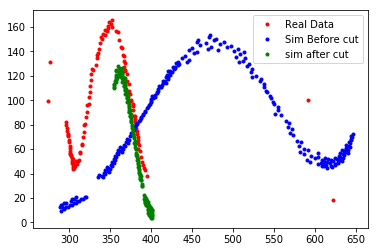

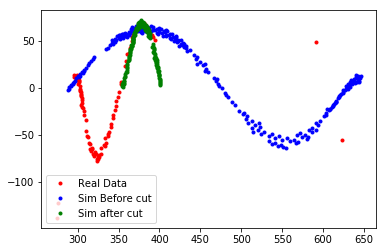

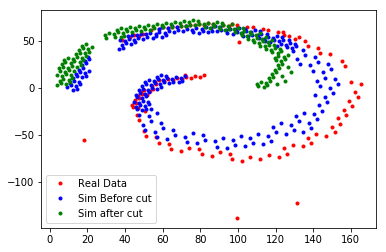

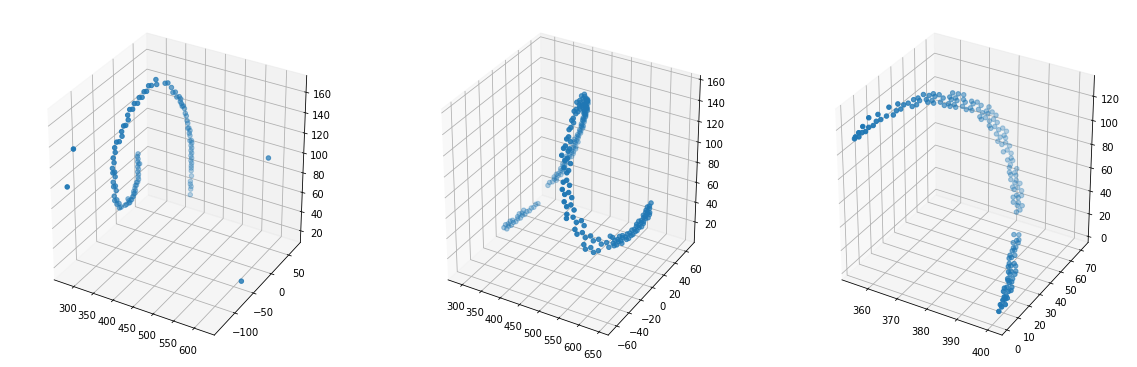

In [337]:
%matplotlib inline

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label='sim after cut')
plt.legend(loc=1)
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])

<IPython.core.display.Javascript object>


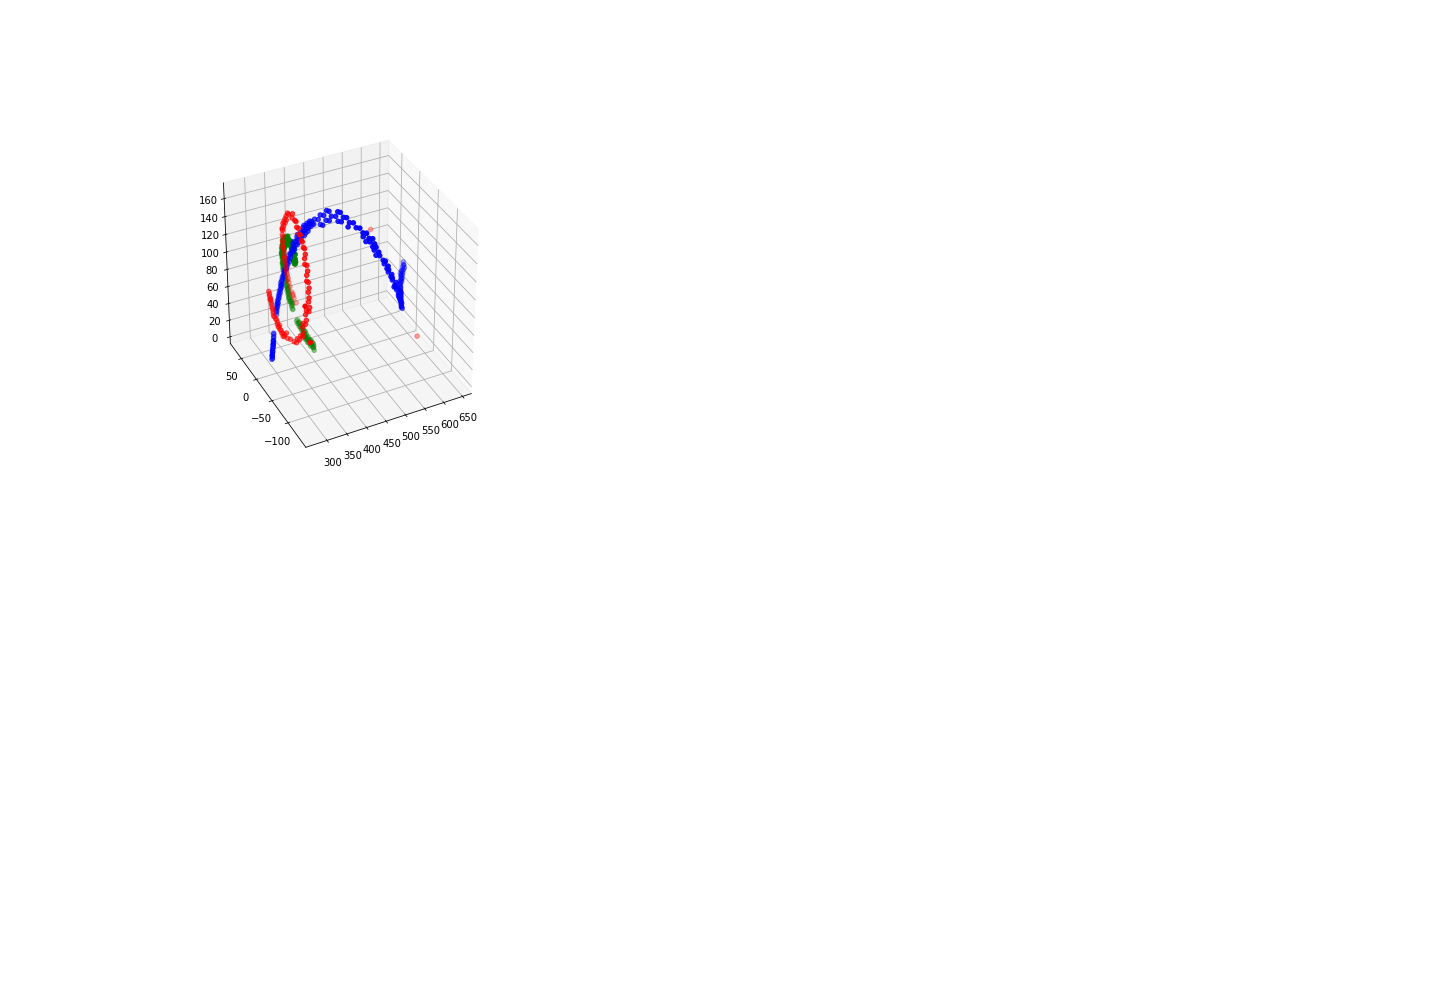

In [338]:
%matplotlib notebook
fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5],c='r')
ax.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5],c='b')
ax.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5],c='g')


In [302]:
scipy.optimize.fmin_bfgs(cut_f, cut_ctr0, fprime=cut_jacobian, callback=cut_callbackF)

   2 0.005744 0.001835 0.947580 1.651355-1.205513 2.022092 96.116202
         Current function value: 96.116202
         Iterations: 1
         Function evaluations: 98
         Gradient evaluations: 90


array([ 5.74378889e-03,  1.83526220e-03,  9.47579550e-01,  1.65135498e+00,
       -1.20551273e+00,  2.02209155e+00])

Differential Evolution

In [339]:
i = 1
def callbackF(x, convergence=10):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1
bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]
results = scipy.optimize.differential_evolution(f, bounds, callback=callbackF, maxiter=1000, strategy='best1bin',\
                                                recombination=0.3, popsize=25, mutation=(0.5, 1.0))
'''    The differential evolution strategy should be one of:
            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result
            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result
            ‘rand1exp’ - takes a long time but converges
            ‘randtobest1exp’ - takes a long time but converges
            ‘currenttobest1exp’ - takes a long time but converges
            ‘best2exp’
            ‘rand2exp’
            ‘randtobest1bin’
            ‘currenttobest1bin’
            ‘best2bin’
            ‘rand2bin’
            ‘rand1bin’
    The default is ‘best1bin’.
'''

   1 0.038066-0.025473 0.259706 2.468160 1.525210 1.109219 153.963700
   2-0.021326 0.030593 0.989350 4.512361-5.334705-5.649366 142.495454
   3-0.018388-0.001910 0.500297 0.017083-1.523578-4.199930 123.709388
   4-0.018388-0.001910 0.500297 0.017083-1.523578-4.199930 123.709388
   5-0.018388-0.001910 0.500297 0.017083-1.523578-4.199930 123.709388
   6-0.021326-0.009412 0.460433 4.512361-5.334705-5.632336 122.280552
   7 0.011580-0.007428 0.300254 4.349933-3.824938-5.005492 118.263217
   8 0.011580-0.007428 0.300254 4.349933-3.824938-5.005492 118.263217
   9 0.012849 0.002810 0.287080 2.498762 4.786269-0.707758 106.938770
  10 0.011580-0.007428 0.300254 4.349933 0.629743-5.005492 103.440068
  11 0.011580-0.007428 0.300254 4.349933 0.629743-5.005492 103.440068
  12 0.012849 0.002810 0.573843 2.498762 4.786269-2.714406 99.926263
  13 0.012849 0.002810 0.573843 2.498762 4.786269-2.714406 99.926263
  14 0.023112-0.001483 0.290580 3.327196 1.164174 0.897087 97.521602
  15 0.023112-0.001483 

 120 0.003177 0.009612 0.538940 4.598101-1.187085 4.489956 81.357293
 121 0.003177 0.009612 0.538940 4.598101-1.187085 4.489956 81.357293
 122 0.003177 0.009612 0.538940 4.598101-1.187085 4.489956 81.357293
 123 0.003177 0.009612 0.538940 4.598101-1.187085 4.489956 81.357293
 124 0.003177 0.009612 0.538940 4.598101-1.187085 4.489956 81.357293
 125 0.003177 0.009612 0.538940 4.598101-1.187085 4.489956 81.357293
 126 0.003177 0.009612 0.538940 4.598101-1.187085 4.489956 81.357293
 127 0.003177 0.009612 0.538940 4.598101-1.187085 4.489956 81.357293
 128 0.003177 0.009612 0.538940 4.598101-1.187085 4.489956 81.357293
 129 0.003177 0.008978 0.538940 4.598101-1.187085 4.489956 81.338519
 130 0.003177 0.008978 0.538940 4.598101-1.187085 4.489956 81.338519
 131 0.003177 0.008978 0.538940 4.598101-1.187085 4.489956 81.338519
 132 0.003177 0.008978 0.538940 4.598101-1.187085 4.489956 81.338519
 133 0.003177 0.008978 0.538940 4.598101-1.187085 4.489956 81.338519
 134 0.003177 0.008978 0.538940 4.

 239 0.009727 0.008714 0.415863 0.951916 1.014574-4.306453 71.496228
 240 0.009727 0.008714 0.415863 0.951916 1.014574-4.306453 71.496228
 241 0.009727 0.008714 0.415863 0.951916 1.014574-4.306453 71.496228
 242 0.009727 0.008714 0.415863 0.951916 1.014574-4.306453 71.496228
 243 0.009727 0.008714 0.415863 0.951916 1.014574-4.306453 71.496228
 244 0.009727 0.008714 0.415863 0.951916 1.014574-4.306453 71.496228
 245 0.009727 0.008714 0.415863 0.951916 1.014574-4.306453 71.496228
 246 0.009727 0.008714 0.415863 0.951916 1.014574-4.306453 71.496228
 247 0.009727 0.008714 0.415863 0.951916 1.014574-4.306453 71.496228
 248 0.009727 0.008714 0.415863 0.951916 1.014574-4.306453 71.496228
 249 0.009727 0.008714 0.415863 0.951916 1.014574-4.306453 71.496228
 250 0.009727 0.008714 0.415863 0.951916 1.014574-4.306453 71.496228
 251 0.009727 0.008714 0.415863 0.951916 1.014574-4.306453 71.496228
 252 0.009727 0.008714 0.415863 0.951916 1.014574-4.306453 71.496228
 253 0.009727 0.008714 0.415863 0.

 358 0.004198 0.004028 0.418317 0.979223 1.145837-4.328171 62.342908
 359 0.004198 0.004028 0.418317 0.979223 1.145837-4.328171 62.342908
 360 0.004198 0.004028 0.418317 0.979223 1.145837-4.328171 62.342908
 361 0.003843 0.004530 0.418317 0.979223 1.145837-4.328171 62.328943
 362 0.003843 0.004530 0.418317 0.979223 1.145837-4.328171 62.328943
 363 0.003843 0.004530 0.418317 0.979223 1.145837-4.328171 62.328943
 364 0.003843 0.004530 0.418317 0.979223 1.145837-4.328171 62.328943
 365 0.003843 0.004530 0.418317 0.979223 1.145837-4.328171 62.328943
 366 0.003843 0.004530 0.418317 0.979223 1.145837-4.328171 62.328943
 367 0.003843 0.004530 0.418317 0.979223 1.145837-4.328171 62.328943
 368 0.003843 0.004530 0.418317 0.979223 1.145837-4.328171 62.328943
 369 0.003843 0.004530 0.418317 0.979223 1.145837-4.328171 62.328943
 370 0.003843 0.004530 0.418317 0.979223 1.145837-4.328171 62.328943
 371 0.003843 0.004530 0.418317 0.979223 1.145837-4.328171 62.328943
 372 0.003843 0.004530 0.418317 0.

 477 0.004138 0.009693 0.409828 1.094343 1.188863-4.421228 51.481173
 478 0.004138 0.009693 0.409828 1.094343 1.188863-4.421228 51.481173
 479 0.004138 0.009693 0.409828 1.094343 1.188863-4.421228 51.481173
 480 0.004138 0.009693 0.409828 1.094343 1.188863-4.421228 51.481173
 481 0.004138 0.009693 0.409828 1.094343 1.188863-4.421228 51.481173
 482 0.003042 0.009693 0.409828 1.094343 1.188863-4.421228 51.247991
 483 0.003042 0.009693 0.409828 1.094343 1.188863-4.421228 51.247991
 484 0.003042 0.009693 0.409828 1.094343 1.188863-4.421228 51.247991
 485 0.003042 0.009693 0.409828 1.094343 1.188863-4.421228 51.247991
 486 0.003042 0.009693 0.409828 1.094343 1.188863-4.421228 51.247991
 487 0.003042 0.009693 0.409828 1.094343 1.188863-4.421228 51.247991
 488 0.003042 0.009693 0.409828 1.094343 1.188863-4.421228 51.247991
 489 0.003042 0.009693 0.409828 1.094343 1.188863-4.421228 51.247991
 490 0.003042 0.009693 0.409828 1.094343 1.188863-4.421228 51.247991
 491 0.003042 0.009693 0.409828 1.

 596 0.008583 0.013600 0.405192 1.364857 4.428368-1.784326 39.834705
 597 0.008583 0.013600 0.405192 1.364857 4.428368-1.784326 39.834705
 598 0.008583 0.013600 0.405192 1.364857 4.428368-1.784326 39.834705
 599 0.008583 0.013600 0.405192 1.364857 4.428368-1.784326 39.834705
 600 0.008583 0.012222 0.405192 1.364857 4.428368-1.784326 39.395792
 601 0.008583 0.012222 0.405192 1.364857 4.428368-1.784326 39.395792
 602 0.008583 0.012222 0.405192 1.364857 4.428368-1.784326 39.395792
 603 0.008583 0.012222 0.405192 1.364857 4.428368-1.784326 39.395792
 604 0.008583 0.012222 0.405192 1.364857 4.428368-1.784326 39.395792
 605 0.009270 0.012627 0.403700 1.364857 4.428368-1.784326 39.234820
 606 0.009270 0.012627 0.403700 1.364857 4.428368-1.784326 39.234820
 607 0.009270 0.012627 0.403700 1.364857 4.428368-1.784326 39.234820
 608 0.009270 0.012627 0.403700 1.364857 4.428368-1.784326 39.234820
 609 0.009270 0.012627 0.403700 1.364857 4.428368-1.784326 39.234820
 610 0.009270 0.012627 0.403700 1.

 715-0.001040 0.000229 0.405192 1.364857 4.428368-1.784326 27.948939
 716-0.001040 0.000229 0.405192 1.364857 4.428368-1.784326 27.948939
 717-0.001040 0.000229 0.405192 1.364857 4.428368-1.784326 27.948939
 718-0.001040 0.000229 0.405192 1.364857 4.428368-1.784326 27.948939
 719-0.001040 0.000229 0.405192 1.364857 4.428368-1.784326 27.948939
 720-0.001040 0.000229 0.405192 1.364857 4.428368-1.784326 27.948939
 721-0.001040 0.000229 0.405192 1.364857 4.428368-1.784326 27.948939
 722-0.001040 0.000229 0.405192 1.364857 4.428368-1.784326 27.948939
 723-0.001040 0.000229 0.405192 1.364857 4.428368-1.784326 27.948939
 724-0.001040 0.000229 0.405192 1.364857 4.428368-1.784326 27.948939
 725-0.001040 0.000229 0.405192 1.364857 4.428368-1.784326 27.948939
 726-0.001040 0.000229 0.405192 1.364857 4.428368-1.784326 27.948939
 727-0.000841 0.002067 0.405192 1.364857 4.428368-1.784326 27.526655
 728-0.000841 0.002067 0.405192 1.364857 4.428368-1.784326 27.526655
 729-0.000841 0.002067 0.405192 1.

 834-0.001320 0.002394 0.405192 1.364857 4.428368-1.784326 26.821679
 835-0.001320 0.002394 0.405192 1.364857 4.428368-1.784326 26.821679
 836-0.001320 0.002394 0.405192 1.364857 4.428368-1.784326 26.821679
 837-0.001320 0.002394 0.405192 1.364857 4.428368-1.784326 26.821679
 838-0.001320 0.002394 0.405192 1.364857 4.428368-1.784326 26.821679
 839-0.001320 0.002394 0.405192 1.364857 4.428368-1.784326 26.821679
 840-0.001320 0.002394 0.405192 1.364857 4.428368-1.784326 26.821679
 841-0.001320 0.002394 0.405192 1.364857 4.428368-1.784326 26.821679
 842-0.001320 0.002394 0.405192 1.364857 4.428368-1.784326 26.821679
 843-0.001320 0.002394 0.405192 1.364857 4.428368-1.784326 26.821679
 844-0.001320 0.002394 0.405192 1.364857 4.428368-1.784326 26.821679
 845-0.001320 0.002394 0.405192 1.364857 4.428368-1.784326 26.821679
 846-0.001320 0.002394 0.405192 1.364857 4.428368-1.784326 26.821679
 847-0.001320 0.002394 0.405192 1.364857 4.428368-1.784326 26.821679
 848-0.001320 0.002394 0.405192 1.

 953-0.002979 0.004647 0.405192 1.364857 4.428368-1.784326 26.716831
 954-0.002979 0.004647 0.405192 1.364857 4.428368-1.784326 26.716831
 955-0.002979 0.004647 0.405192 1.364857 4.428368-1.784326 26.716831
 956-0.002979 0.004647 0.405192 1.364857 4.428368-1.784326 26.716831
 957-0.002979 0.004647 0.405192 1.364857 4.428368-1.784326 26.716831
 958-0.002979 0.004647 0.405192 1.364857 4.428368-1.784326 26.716831
 959-0.002979 0.004647 0.405192 1.364857 4.428368-1.784326 26.716831
 960-0.002979 0.004647 0.405192 1.364857 4.428368-1.784326 26.716831
 961-0.002979 0.004647 0.405192 1.364857 4.428368-1.784326 26.716831
 962-0.002979 0.004647 0.405192 1.364857 4.428368-1.784326 26.716831
 963-0.002979 0.004647 0.405192 1.364857 4.428368-1.784326 26.716831
 964-0.002979 0.004647 0.405192 1.364857 4.428368-1.784326 26.716831
 965-0.002979 0.004647 0.405192 1.364857 4.428368-1.784326 26.716831
 966-0.002979 0.004647 0.405192 1.364857 4.428368-1.784326 26.716831
 967-0.002979 0.004647 0.405192 1.

'    The differential evolution strategy should be one of:\n            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result\n            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result\n            ‘rand1exp’ - takes a long time but converges\n            ‘randtobest1exp’ - takes a long time but converges\n            ‘currenttobest1exp’ - takes a long time but converges\n            ‘best2exp’\n            ‘rand2exp’\n            ‘randtobest1bin’\n            ‘currenttobest1bin’\n            ‘best2bin’\n            ‘rand2bin’\n            ‘rand1bin’\n    The default is ‘best1bin’.\n'

In [340]:
results.fun #30.26455552871073 

26.716830886995634

In [341]:
dfe = results.x
print(dfe)
#evt_299:[ 7.84428822e-03  3.53398504e-03  9.23208704e-01  2.58491529e+00 -9.73837034e-01 -4.45947600e+00]
#evt_399: [ 0.00773186  0.01781402  0.8011877   3.11712508 -0.46023263 -4.4246107 ]


[-2.97865912e-03  4.64651668e-03  4.05192212e-01  1.36485689e+00
  4.42836794e+00 -1.78432586e+00]


In [342]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(dfe[0], dfe[1], dfe[2], dfe[3], dfe[4], dfe[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


In [343]:
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values

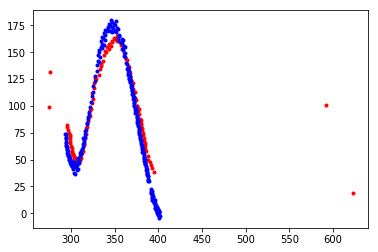

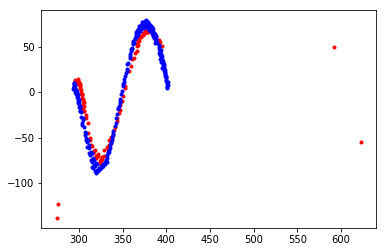

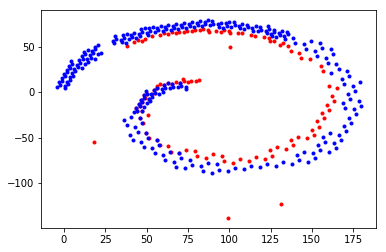

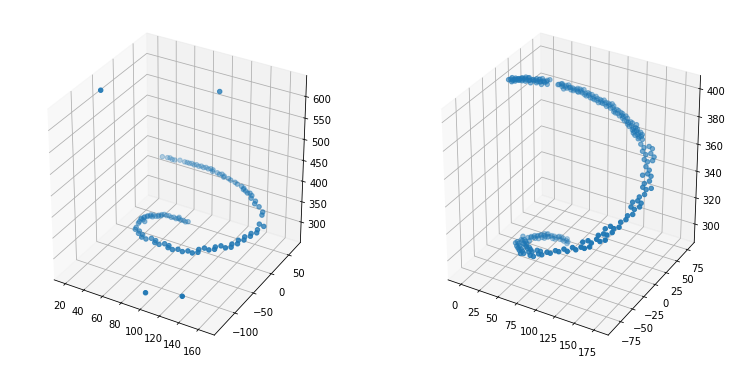

In [344]:
%matplotlib inline
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,5],uvw_values[:,6],uvw_values[:,7])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,5],sim_uvw_values[:,6],sim_uvw_values[:,7])

In [345]:
i = 1
def cut_callbackF(x, convergence=10):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],cut_f(x)))
    i += 1
bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]
results = scipy.optimize.differential_evolution(cut_f, bounds, callback=cut_callbackF, maxiter=1000, strategy='best1bin',\
                                                recombination=0.3, popsize=25, mutation=(0.5, 1.0))
'''    The differential evolution strategy should be one of:
            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result
            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result
            ‘rand1exp’ - takes a long time but converges
            ‘randtobest1exp’ - takes a long time but converges
            ‘currenttobest1exp’ - takes a long time but converges
            ‘best2exp’
            ‘rand2exp’
            ‘randtobest1bin’
            ‘currenttobest1bin’
            ‘best2bin’
            ‘rand2bin’
            ‘rand1bin’
    The default is ‘best1bin’.
'''

   1 0.053092-0.117413 0.618372 1.695755 2.011897 1.090556 448.333548
   2-0.044346-0.033762 0.874271 1.080338-1.681106 1.447419 179.290215
   3 0.016965 0.046569 0.285226 2.336423 3.564654 0.249204 166.243466
   4-0.019063-0.035480 0.657617 0.650291 6.085718 0.946533 149.606268
   5-0.007953 0.029863 0.075469 3.572841 6.213620 1.714553 135.866695
   6 0.009071-0.022474 0.718929 0.476540 0.237330-2.465009 128.909202
   7 0.009071-0.022474 0.718929 0.476540 0.237330-2.465009 128.909202
   8 0.009071-0.022474 0.718929 0.476540 0.237330-2.465009 128.909202
   9 0.014877-0.006732 0.867796 3.891143-3.365358 2.685181 121.891411
  10 0.018770 0.012033 0.435160 2.334679 5.784988-3.330351 110.535237
  11 0.013315 0.002125 0.494232 2.427000-0.210154 3.047420 108.612971
  12-0.011549-0.006732 0.867796 2.560973-3.365358 2.685181 95.106057
  13-0.011549-0.006732 0.867796 2.560973-3.365358 2.685181 95.106057
  14-0.011549-0.006732 0.867796 2.560973-3.365358 2.685181 95.106057
  15-0.005736-0.006732 

 120 0.002041 0.002541 0.395653 1.402618-5.312654 1.758596 68.881129
 121 0.002041 0.002541 0.395653 1.402618-5.312654 1.758596 68.881129
 122 0.002041 0.002541 0.395653 1.402618-5.312654 1.758596 68.881129
 123 0.002041 0.002541 0.395653 1.402618-5.004911 1.758596 38.666384
 124 0.002041 0.002541 0.395653 1.402618-5.004911 1.758596 38.666384
 125 0.002041 0.002541 0.395653 1.402618-5.004911 1.758596 38.666384
 126 0.002041 0.002541 0.395653 1.402618-5.004911 1.758596 38.666384
 127 0.002041 0.002541 0.395653 1.402618-5.004911 1.758596 38.666384
 128 0.002041 0.002541 0.395653 1.402618-5.004911 1.758596 38.666384
 129 0.002041 0.002541 0.395653 1.402618-5.004911 1.758596 38.666384
 130 0.002041 0.002541 0.395653 1.402618-5.004911 1.758596 38.666384
 131 0.002041 0.002541 0.395653 1.402618-5.004911 1.758596 38.666384
 132 0.002041 0.002541 0.395653 1.402618-5.004911 1.758596 38.666384
 133 0.002041 0.002541 0.395653 1.402618-5.004911 1.758596 38.666384
 134 0.002041 0.002541 0.395653 1.

 240-0.000073 0.007523 0.395653 1.402618-5.004911 1.758596 37.535360
 241-0.000073 0.007523 0.395653 1.402618-5.004911 1.758596 37.535360
 242-0.000073 0.007523 0.395653 1.402618-5.004911 1.758596 37.535360
 243-0.000073 0.007523 0.395653 1.402618-5.004911 1.758596 37.535360
 244-0.000073 0.007523 0.395653 1.402618-5.004911 1.758596 37.535360
 245-0.000073 0.007523 0.395653 1.402618-5.004911 1.758596 37.535360
 246-0.000073 0.007523 0.395653 1.402618-5.004911 1.758596 37.535360
 247-0.000073 0.007523 0.395653 1.402618-5.004911 1.758596 37.535360
 248-0.000073 0.007523 0.395653 1.402618-5.004911 1.758596 37.535360
 249-0.000073 0.007523 0.395653 1.402618-5.004911 1.758596 37.535360
 250-0.000073 0.007523 0.395653 1.402618-5.004911 1.758596 37.535360
 251-0.000073 0.007523 0.395653 1.402618-5.004911 1.758596 37.535360
 252-0.000073 0.007523 0.395653 1.402618-5.004911 1.758596 37.535360
 253-0.000073 0.007523 0.395653 1.402618-5.004911 1.758596 37.535360
 254-0.000073 0.007523 0.395653 1.

 360 0.000831 0.007523 0.395653 1.402618-5.004911 1.758596 37.046132
 361 0.000831 0.007523 0.395653 1.402618-5.004911 1.758596 37.046132
 362 0.000831 0.007523 0.395653 1.402618-5.004911 1.758596 37.046132
 363 0.000831 0.007523 0.395653 1.402618-5.004911 1.758596 37.046132
 364 0.000831 0.007523 0.395653 1.402618-5.004911 1.758596 37.046132
 365 0.000831 0.007523 0.395653 1.402618-5.004911 1.758596 37.046132
 366 0.000831 0.007523 0.395653 1.402618-5.004911 1.758596 37.046132
 367 0.000831 0.007523 0.395653 1.402618-5.004911 1.758596 37.046132
 368 0.000831 0.007523 0.395653 1.402618-5.004911 1.758596 37.046132
 369 0.000831 0.007523 0.395653 1.402618-5.004911 1.758596 37.046132
 370 0.000831 0.007523 0.395653 1.402618-5.004911 1.758596 37.046132
 371 0.000831 0.007523 0.395653 1.402618-5.004911 1.758596 37.046132
 372 0.000831 0.007523 0.395653 1.402618-5.004911 1.758596 37.046132
 373 0.000831 0.007523 0.395653 1.402618-5.004911 1.758596 37.046132
 374 0.000831 0.007523 0.395653 1.

 480 0.004468 0.008239 0.395653 1.402618-5.070583 1.758596 34.931683
 481 0.004468 0.008239 0.395653 1.402618-5.070583 1.758596 34.931683
 482 0.004468 0.008239 0.395653 1.402618-5.070583 1.758596 34.931683
 483 0.004468 0.008239 0.395653 1.402618-5.070583 1.758596 34.931683
 484 0.004468 0.008239 0.395653 1.402618-5.070583 1.758596 34.931683
 485 0.004468 0.008239 0.395653 1.402618-5.070583 1.758596 34.931683
 486 0.004468 0.008239 0.395653 1.402618-5.070583 1.758596 34.931683
 487 0.004468 0.008239 0.395653 1.402618-5.070583 1.758596 34.931683
 488 0.004468 0.008239 0.395653 1.402618-5.070583 1.758596 34.931683
 489 0.004468 0.008239 0.395653 1.402618-5.070583 1.758596 34.931683
 490 0.004468 0.008239 0.395653 1.402618-5.070583 1.758596 34.931683
 491 0.004468 0.008239 0.395653 1.402618-5.070583 1.758596 34.931683
 492 0.004468 0.008239 0.395653 1.402618-5.070583 1.758596 34.931683
 493 0.004468 0.008239 0.395653 1.402618-5.070583 1.758596 34.931683
 494 0.004468 0.008239 0.395653 1.

 600 0.003669 0.008349 0.395653 1.402618-5.070583 1.758596 34.843244
 601 0.003669 0.008349 0.395653 1.402618-5.070583 1.758596 34.843244
 602 0.003669 0.008349 0.395653 1.402618-5.070583 1.758596 34.843244
 603 0.003669 0.008349 0.395653 1.402618-5.070583 1.758596 34.843244
 604 0.003669 0.008349 0.395653 1.402618-5.070583 1.758596 34.843244
 605 0.003669 0.008349 0.395653 1.402618-5.070583 1.758596 34.843244
 606 0.003669 0.008349 0.395653 1.402618-5.070583 1.758596 34.843244
 607 0.003669 0.008349 0.395653 1.402618-5.070583 1.758596 34.843244
 608 0.003669 0.008349 0.395653 1.402618-5.070583 1.758596 34.843244
 609 0.003669 0.008349 0.395653 1.402618-5.070583 1.758596 34.843244
 610 0.003669 0.008349 0.395653 1.402618-5.070583 1.758596 34.843244
 611 0.003669 0.008349 0.395653 1.402618-5.070583 1.758596 34.843244
 612 0.003669 0.008349 0.395653 1.402618-5.070583 1.758596 34.843244
 613 0.003669 0.008349 0.395653 1.402618-5.070583 1.758596 34.843244
 614 0.003669 0.008349 0.395653 1.

 720-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 721-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 722-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 723-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 724-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 725-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 726-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 727-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 728-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 729-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 730-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 731-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 732-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 733-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 734-0.002482 0.013364 0.410231 1.

 840-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 841-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 842-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 843-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 844-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 845-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 846-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 847-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 848-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 849-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 850-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 851-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 852-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 853-0.002482 0.013364 0.410231 1.277255-5.118267-4.463439 32.746873
 854-0.002482 0.013364 0.410231 1.

 960 0.001788 0.006019 0.399284 1.406163-5.074971-4.517096 29.241006
 961 0.001788 0.006019 0.399284 1.406163-5.074971-4.517096 29.241006
 962 0.001788 0.006019 0.399284 1.406163-5.074971-4.517096 29.241006
 963 0.001788 0.006019 0.399284 1.406163-5.074971-4.517096 29.241006
 964 0.001788 0.006019 0.399284 1.406163-5.074971-4.517096 29.241006
 965 0.001788 0.006019 0.399284 1.406163-5.074971-4.517096 29.241006
 966 0.001788 0.006019 0.399284 1.406163-5.074971-4.517096 29.241006
 967 0.001788 0.006019 0.399284 1.406163-5.074971-4.517096 29.241006
 968 0.001788 0.006019 0.399284 1.406163-5.074971-4.517096 29.241006
 969 0.001788 0.006019 0.399284 1.406163-5.074971-4.517096 29.241006
 970 0.001788 0.006019 0.399284 1.406163-5.074971-4.517096 29.241006
 971 0.001788 0.006019 0.399284 1.406163-5.074971-4.517096 29.241006
 972 0.001788 0.006019 0.399284 1.406163-5.074971-4.517096 29.241006
 973 0.001788 0.006019 0.399284 1.406163-5.074971-4.517096 29.241006
 974 0.001788 0.006019 0.399284 1.

'    The differential evolution strategy should be one of:\n            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result\n            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result\n            ‘rand1exp’ - takes a long time but converges\n            ‘randtobest1exp’ - takes a long time but converges\n            ‘currenttobest1exp’ - takes a long time but converges\n            ‘best2exp’\n            ‘rand2exp’\n            ‘randtobest1bin’\n            ‘currenttobest1bin’\n            ‘best2bin’\n            ‘rand2bin’\n            ‘rand1bin’\n    The default is ‘best1bin’.\n'

In [310]:
cut_dfe = results.x

In [311]:
cut_evtClean, cut_ctr = sim.make_event(cut_dfe[0], cut_dfe[1], cut_dfe[2], cut_dfe[3], cut_dfe[4], cut_dfe[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


In [312]:
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

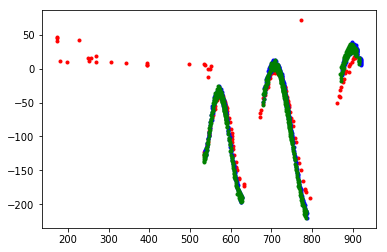

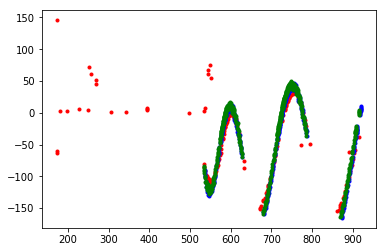

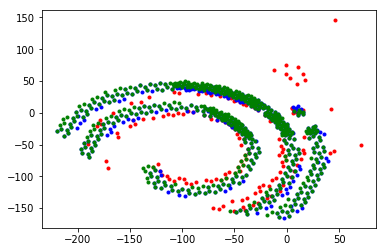

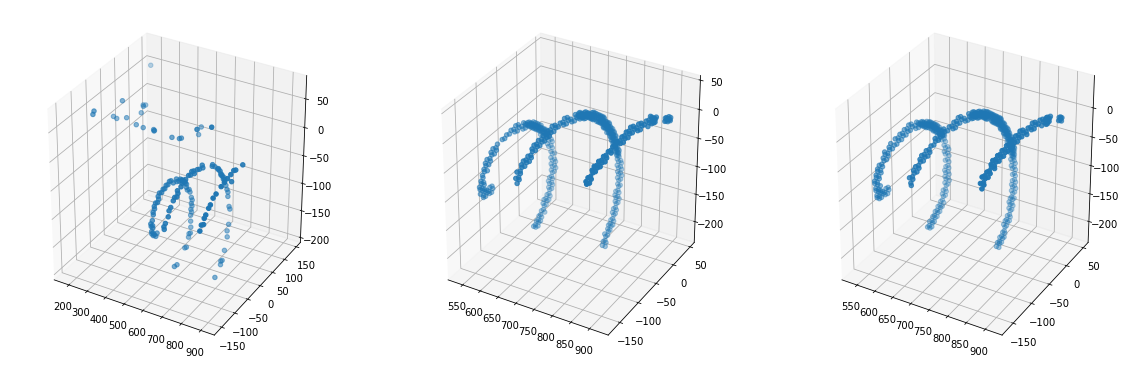

In [313]:
%matplotlib inline
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.')
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])


<IPython.core.display.Javascript object>


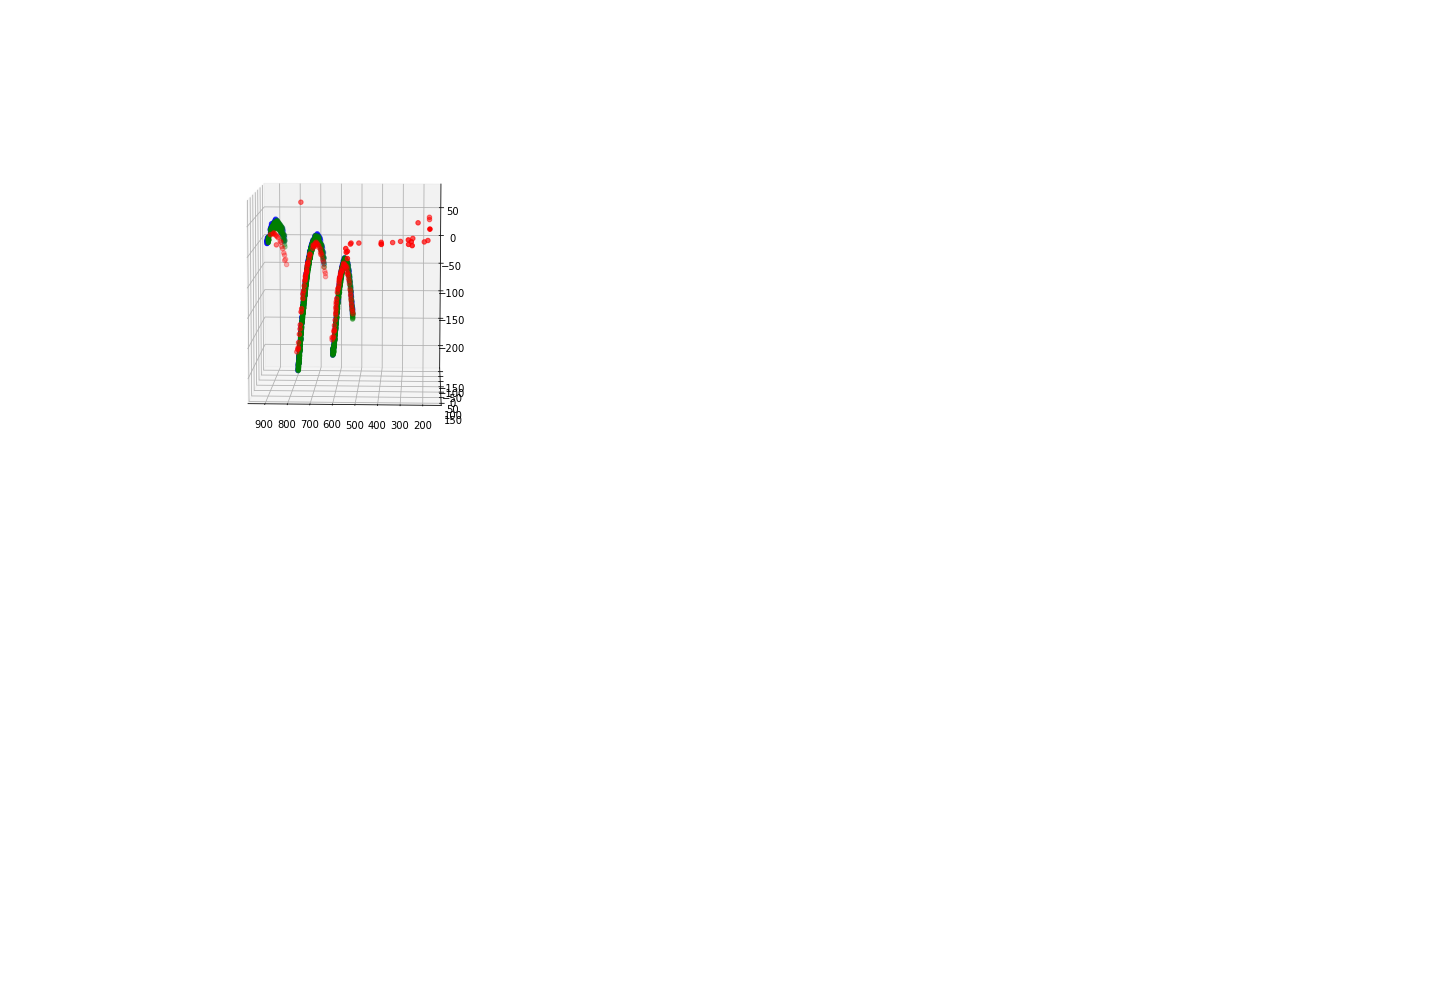

In [315]:
%matplotlib notebook

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5],c='r')
ax.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5],c='b')
ax.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5],c='g')

In [265]:
i = 1
def callbackF(x, f, accept):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f))
    i += 1

results = scipy.optimize.basinhopping(f,ctr0, callback=callbackF, niter=100, T=20, stepsize=0.1, minimizer_kwargs={"method": "CG"})
print(results)

   1 0.005610 0.006559 0.976190 1.479204-1.208006 2.073016 93.474424
   2 0.009132-0.001432 0.980131 1.445298-1.298643 2.097076 94.759304
   3-0.000000-0.000000 1.075648 1.412952-1.357610 2.114124 108.460895
   4-0.000000-0.000000 1.049410 1.361056-1.454231 2.090265 108.864572
   5 0.002611-0.001571 0.989211 1.450694-1.376492 2.121791 96.308566
   6-0.000000-0.000000 1.084920 1.506768-1.329631 2.060614 106.085391
   7 0.000474-0.000396 1.136004 1.569682-1.425042 1.980571 105.216821
   8-0.007447-0.089169 1.199526 1.552676-1.375228 2.016354 267.232118
   9-0.000000-0.000000 1.122563 1.521042-1.421553 2.006080 106.350728
  10-0.058239 0.007145 1.023320 1.452626-1.453856 2.054307 177.448238
  11-0.072681 0.005929 1.222521 1.470309-1.356240 1.956658 213.596618
  12-0.097629-0.055215 1.094994 1.470913-1.323093 2.030580 359.067842
  13 0.019387 0.085346 1.218634 1.589939-1.428779 1.982047 260.846059
  14-0.000000-0.000000 1.150714 1.484678-1.459510 1.956475 106.524344
  15-0.015475-0.060528 

In [35]:
bh = results.x #46.918505571793425